## IMPORTS

In [ ]:
import os
import json
import numpy as np
import re
import trimesh
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import open_clip

# CLIP config
CLIP_BACKBONE = "ViT-B-16"
CLIP_CHECKPOINT = "datacomp_xl_s13b_b90k"
CLIP_OUTPUT_SIZE = 512

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


/opt/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda


In [ ]:
#paths

ply_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair_webots.ply"
rgb_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair_webots/image.jpg"
mask_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair_webots/0.png"
k_txt_path   = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair_webots/intrinsics.txt"
ext_txt_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair_webots/extrinsics.txt"


## Helper Functions

In [ ]:
def load_point_cloud_ply(path):
    mesh = trimesh.load(path)
    if hasattr(mesh, "vertices"):
        pts = np.asarray(mesh.vertices, dtype=np.float32)
    elif hasattr(mesh, "points"):
        pts = np.asarray(mesh.points, dtype=np.float32)
    else:
        raise ValueError(f"Unknown trimesh object type: {type(mesh)}")

    print(f"Loaded point cloud from {path}: {pts.shape}")
    print("Min coords:", pts.min(axis=0))
    print("Max coords:", pts.max(axis=0))
    return pts

points = load_point_cloud_ply(ply_path)


Loaded point cloud from /home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair_webots.ply: (140640, 3)
Min coords: [-0.23992461 -0.28552353 -0.50241655]
Max coords: [0.23680502 0.28364944 0.4987536 ]


In [ ]:
def load_rgb_and_mask(rgb_path, mask_path):
    rgb = np.array(Image.open(rgb_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))  # grayscale
    mask_bin = (mask > 0).astype(np.uint8)

    print(f"Loaded RGB {rgb.shape} and mask {mask.shape}")
    return rgb, mask_bin

rgb, mask = load_rgb_and_mask(rgb_path, mask_path)
H, W, _ = rgb.shape
print("H, W:", H, W)


Loaded RGB (324, 324, 3) and mask (324, 324)
H, W: 324 324


In [ ]:
def load_webots_K(k_path: str) -> np.ndarray:
    with open(k_path, "r") as f:
        txt = f.read()

    # pull all floats (handles decimals / scientific)
    nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", txt)
    vals = [float(x) for x in nums]

    if len(vals) < 9:
        raise ValueError(f"Could not parse 9 numbers from K file: {k_path}")

    K = np.array(vals[:9], dtype=np.float32).reshape(3, 3)
    return K

def load_webots_extrinsic(ext_path: str) -> np.ndarray:
    with open(ext_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]

    # take last 3 non-empty lines that contain 4 floats each
    rows = []
    for ln in lines:
        nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", ln)
        if len(nums) == 4:
            rows.append([float(x) for x in nums])

    if len(rows) < 3:
        raise ValueError(f"Could not find 3 rows of 4 floats in extrinsic file: {ext_path}")

    R_t = np.array(rows[-3:], dtype=np.float32)  # 3x4
    T = np.eye(4, dtype=np.float32)
    T[:3, :4] = R_t
    return T

K = load_webots_K(k_txt_path)
T_raw = load_webots_extrinsic(ext_txt_path)

print("Loaded Webots K:\n", K)
print("Loaded Webots T_raw (4x4):\n", T_raw)


Loaded Webots K:
 [[348.622   0.    162.   ]
 [  0.    348.622 162.   ]
 [  0.      0.      1.   ]]
Loaded Webots T_raw (4x4):
 [[ 1.00000e+00  3.51000e-04 -0.00000e+00 -2.85239e-01]
 [-3.51000e-04  1.00000e+00 -0.00000e+00 -5.13631e-01]
 [ 0.00000e+00  0.00000e+00  1.00000e+00  6.16010e-01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]


In [ ]:
# projection & choosing camera convention

def project_points(points, K, w2c):
    """
    points: (N, 3)
    K: (3, 3)
    w2c: (4, 4)
    Returns:
        pixels: (N, 2)
        depths: (N,)
    """
    N = points.shape[0]
    pts_h = np.hstack([points, np.ones((N, 1), dtype=np.float32)])  # N×4
    pts_cam = (w2c @ pts_h.T).T                                      # N×4
    X, Y, Z = pts_cam[:,0], pts_cam[:,1], pts_cam[:,2]

    eps = 1e-6
    Z_safe = np.where(Z == 0, eps, Z)
    x = X / Z_safe
    y = Y / Z_safe

    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]
    u = fx * x + cx
    v = fy * y + cy

    pixels = np.stack([u, v], axis=-1)
    depths = Z
    return pixels.astype(np.float32), depths.astype(np.float32)

def choose_w2c(points, K, T_raw):
    T_inv = np.linalg.inv(T_raw).astype(np.float32)

    pix1, z1 = project_points(points, K, T_raw)
    pix2, z2 = project_points(points, K, T_inv)

    c1 = (z1 > 0).sum()
    c2 = (z2 > 0).sum()

    print("Points in front: T_raw =", c1, ", inv(T_raw) =", c2)
    if c2 > c1:
        print("=> Using inv(T_raw) as w2c")
        return T_inv
    else:
        print("=> Using T_raw as w2c")
        return T_raw

w2c = choose_w2c(points, K, T_raw)

pixels_raw, depths = project_points(points, K, w2c)
print("Raw u range:", pixels_raw[:,0].min(), pixels_raw[:,0].max())
print("Raw v range:", pixels_raw[:,1].min(), pixels_raw[:,1].max())
print("Points in front (Z>0):", (depths > 0).sum())


Points in front: T_raw = 140640 , inv(T_raw) = 0
=> Using T_raw as w2c
Raw u range: -1359.1769 138.21895
Raw v range: -2202.57 89.98502
Points in front (Z>0): 140640


In [ ]:
# align projected points to mask bounding box

# mask bbox
ys_mask, xs_mask = np.where(mask > 0)
x_min_m, x_max_m = xs_mask.min(), xs_mask.max()
y_min_m, y_max_m = ys_mask.min(), ys_mask.max()
print("Mask bbox x:", x_min_m, x_max_m)
print("Mask bbox y:", y_min_m, y_max_m)

# projected bbox (only Z>0)
front_idx = depths > 0
u_raw = pixels_raw[front_idx, 0]
v_raw = pixels_raw[front_idx, 1]
u_min_p, u_max_p = u_raw.min(), u_raw.max()
v_min_p, v_max_p = v_raw.min(), v_raw.max()
print("Proj bbox u:", u_min_p, u_max_p)
print("Proj bbox v:", v_min_p, v_max_p)


du = u_max_p - u_min_p
dv = v_max_p - v_min_p
mask_w = x_max_m - x_min_m
mask_h = y_max_m - y_min_m

scale_u = mask_w / du
scale_v = mask_h / dv       
shift_u = x_min_m - u_min_p * scale_u
shift_v = y_min_m - v_min_p * scale_v

aligned_u = pixels_raw[:,0] * scale_u + shift_u
aligned_v = pixels_raw[:,1] * scale_v + shift_v


print("Aligned u range:", aligned_u[front_idx].min(), aligned_u[front_idx].max())
print("Aligned v range:", aligned_v[front_idx].min(), aligned_v[front_idx].max())


Mask bbox x: 119 216
Mask bbox y: 103 307
Proj bbox u: -1359.1769 138.21895
Proj bbox v: -2202.57 89.98502
Aligned u range: 119.00001 216.0
Aligned v range: 103.0 307.0


In [ ]:
# visibility mask based on RGB + mask

u_int = np.round(aligned_u).astype(int)
v_int = np.round(aligned_v).astype(int)

in_front = depths > 0
in_img = in_front & (u_int >= 0) & (u_int < W) & (v_int >= 0) & (v_int < H)
print("Step 2 - in image:", in_img.sum())

mask_bin = (mask > 0)
in_mask = np.zeros_like(in_img, dtype=bool)
valid_idx = np.where(in_img)[0]
for idx in valid_idx:
    if mask_bin[v_int[idx], u_int[idx]]:
        in_mask[idx] = True
print("Step 3 - on mask:", in_mask.sum())

patch_size = 56
half = patch_size // 2
patch_ok = in_mask & \
           (u_int >= half) & (u_int < W - half) & \
           (v_int >= half) & (v_int < H - half)
print("Step 4 - patch fits:", patch_ok.sum())

clip_ok = patch_ok
print("Total CLIP-eligible points:", clip_ok.sum())


Step 2 - in image: 140640
Step 3 - on mask: 66077
Step 4 - patch fits: 39644
Total CLIP-eligible points: 39644


In [ ]:

def compute_clip_features_cfnew(points, rgb, mask_bin,
                                aligned_u, aligned_v, depths,
                                clip_ok,
                                patch_size=56,
                                batch_size=16,
                                device=DEVICE):
    H, W, _ = rgb.shape
    half = patch_size // 2
    N = points.shape[0]

    print("Loading CLIP model...")
    model, _, preprocess = open_clip.create_model_and_transforms(
        CLIP_BACKBONE,
        pretrained=CLIP_CHECKPOINT
    )
    model = model.to(device)
    model.eval()

    clip_features = torch.zeros(N, CLIP_OUTPUT_SIZE, device=device)
    is_visible = torch.zeros(N, dtype=torch.bool, device=device)

    u_int = np.round(aligned_u).astype(int)
    v_int = np.round(aligned_v).astype(int)

    with torch.no_grad(), torch.amp.autocast("cuda", enabled=device.startswith("cuda")):
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            patches = []
            idx_list = []

            for idx in range(start, end):
                if not clip_ok[idx]:
                    continue

                u_i = u_int[idx]
                v_i = v_int[idx]
                z   = depths[idx]

                # safety checks
                if z <= 0:
                    continue
                if not (0 <= u_i < W and 0 <= v_i < H):
                    continue
                if not mask_bin[v_i, u_i]:
                    continue
                if u_i < half or u_i >= W - half or v_i < half or v_i >= H - half:
                    continue

                patch = rgb[v_i-half:v_i+half, u_i-half:u_i+half, :]
                pil_patch = Image.fromarray(patch)
                clip_patch = preprocess(pil_patch)
                patches.append(clip_patch)
                idx_list.append(idx)

            if len(patches) == 0:
                continue

            batch_patches = torch.stack(patches, dim=0).to(device)
            feats = model.encode_image(batch_patches)

            for i, p_idx in enumerate(idx_list):
                clip_features[p_idx] = feats[i]
                is_visible[p_idx] = True

    return clip_features, is_visible

clip_features, is_visible = compute_clip_features_cfnew(
    points,
    rgb,
    mask_bin,
    aligned_u,
    aligned_v,
    depths,
    clip_ok,
    patch_size=56,
    batch_size=16,
    device=DEVICE
)

print("CLIP features tensor shape:", clip_features.shape)
print("Visible points (for CLIP):", is_visible.sum().item())


Loading CLIP model...


open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

CLIP features tensor shape: torch.Size([140640, 512])
Visible points (for CLIP): 39644


## Using Old Camera extrinsic

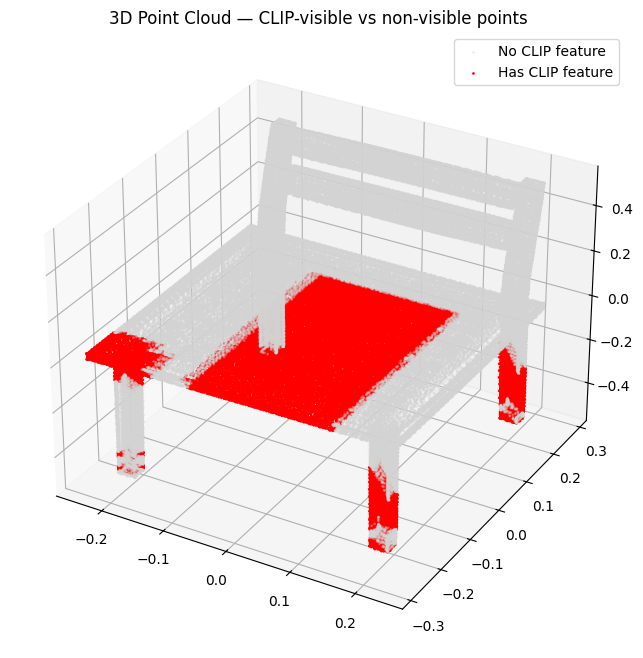

In [ ]:
def visualize_visible_points(points, is_visible, s=1, figsize=(8, 8)):
    if hasattr(is_visible, "cpu"):
        is_visible = is_visible.cpu().numpy()
    if hasattr(points, "cpu"):
        points = points.cpu().numpy()

    vis = is_visible
    non_vis = ~vis

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[non_vis, 0], points[non_vis, 1], points[non_vis, 2],
               s=s, c='lightgray', alpha=0.3, label="No CLIP feature")
    ax.scatter(points[vis, 0], points[vis, 1], points[vis, 2],
               s=s, c='red', alpha=0.9, label="Has CLIP feature")

    ax.set_title("3D Point Cloud — CLIP-visible vs non-visible points")
    ax.legend()
    plt.show()

visualize_visible_points(points, is_visible, s=1)


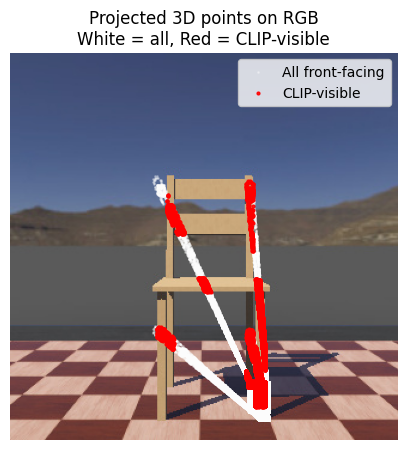

In [ ]:
plt.figure(figsize=(5, 8))
plt.imshow(rgb)
plt.axis("off")

# all front-facing points
plt.scatter(aligned_u[in_front], aligned_v[in_front], s=1, c='white', alpha=0.3, label="All front-facing")

# CLIP-visible points
plt.scatter(aligned_u[is_visible.cpu().numpy()], aligned_v[is_visible.cpu().numpy()],
            s=4, c='red', alpha=0.9, label="CLIP-visible")

plt.title("Projected 3D points on RGB\nWhite = all, Red = CLIP-visible")
plt.legend()
plt.show()


## Using Camera extrinsic from webots
 (using Supervisor of Camera node of Crazyflie)

In [19]:
ext_txt_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair_webots/extrinsic_camera.txt"
K = load_webots_K(k_txt_path)
T_raw = load_webots_extrinsic(ext_txt_path)

print("Loaded Webots K:\n", K)
print("Loaded Webots T_raw (4x4):\n", T_raw)

Loaded Webots K:
 [[348.622   0.    162.   ]
 [  0.    348.622 162.   ]
 [  0.      0.      1.   ]]
Loaded Webots T_raw (4x4):
 [[ 1.0000000e+00  9.7912001e-05 -0.0000000e+00  3.1232080e-01]
 [-9.7912001e-05  1.0000000e+00  0.0000000e+00  5.2534980e-01]
 [ 0.0000000e+00 -0.0000000e+00  1.0000000e+00 -6.4200413e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [20]:
w2c = choose_w2c(points, K, T_raw)

pixels_raw, depths = project_points(points, K, w2c)
print("Raw u range:", pixels_raw[:,0].min(), pixels_raw[:,0].max())
print("Raw v range:", pixels_raw[:,1].min(), pixels_raw[:,1].max())
print("Points in front (Z>0):", (depths > 0).sum())

Points in front: T_raw = 0 , inv(T_raw) = 140640
=> Using inv(T_raw) as w2c
Raw u range: -1144.1274 130.45508
Raw v range: -1792.729 88.05988
Points in front (Z>0): 140640


In [ ]:
#  align projected points to mask bounding box

# mask bbox
ys_mask, xs_mask = np.where(mask > 0)
x_min_m, x_max_m = xs_mask.min(), xs_mask.max()
y_min_m, y_max_m = ys_mask.min(), ys_mask.max()
print("Mask bbox x:", x_min_m, x_max_m)
print("Mask bbox y:", y_min_m, y_max_m)

# projected bbox (only Z>0)
front_idx = depths > 0
u_raw = pixels_raw[front_idx, 0]
v_raw = pixels_raw[front_idx, 1]
u_min_p, u_max_p = u_raw.min(), u_raw.max()
v_min_p, v_max_p = v_raw.min(), v_raw.max()
print("Proj bbox u:", u_min_p, u_max_p)
print("Proj bbox v:", v_min_p, v_max_p)



du = u_max_p - u_min_p
dv = v_max_p - v_min_p
mask_w = x_max_m - x_min_m
mask_h = y_max_m - y_min_m

scale_u = mask_w / du
scale_v = mask_h / dv        # ⬅️ potentially different scales
shift_u = x_min_m - u_min_p * scale_u
shift_v = y_min_m - v_min_p * scale_v

aligned_u = pixels_raw[:,0] * scale_u + shift_u
aligned_v = pixels_raw[:,1] * scale_v + shift_v






print("Aligned u range:", aligned_u[front_idx].min(), aligned_u[front_idx].max())
print("Aligned v range:", aligned_v[front_idx].min(), aligned_v[front_idx].max())


Mask bbox x: 119 216
Mask bbox y: 103 307
Proj bbox u: -1144.1274 130.45508
Proj bbox v: -1792.729 88.05988
Aligned u range: 119.0 216.0
Aligned v range: 103.000015 307.0


In [ ]:
# visibility mask based on RGB + mask

u_int = np.round(aligned_u).astype(int)
v_int = np.round(aligned_v).astype(int)

in_front = depths > 0
in_img = in_front & (u_int >= 0) & (u_int < W) & (v_int >= 0) & (v_int < H)
print("Step 2 - in image:", in_img.sum())

mask_bin = (mask > 0)
in_mask = np.zeros_like(in_img, dtype=bool)
valid_idx = np.where(in_img)[0]
for idx in valid_idx:
    if mask_bin[v_int[idx], u_int[idx]]:
        in_mask[idx] = True
print("Step 3 - on mask:", in_mask.sum())

patch_size = 56
half = patch_size // 2
patch_ok = in_mask & \
           (u_int >= half) & (u_int < W - half) & \
           (v_int >= half) & (v_int < H - half)
print("Step 4 - patch fits:", patch_ok.sum())

clip_ok = patch_ok
print("Total CLIP-eligible points:", clip_ok.sum())


Step 2 - in image: 140640
Step 3 - on mask: 67854
Step 4 - patch fits: 44691
Total CLIP-eligible points: 44691


In [ ]:
# CLIP feature extraction 

def compute_clip_features_cfnew(points, rgb, mask_bin,
                                aligned_u, aligned_v, depths,
                                clip_ok,
                                patch_size=56,
                                batch_size=16,
                                device=DEVICE):
    H, W, _ = rgb.shape
    half = patch_size // 2
    N = points.shape[0]

    print("Loading CLIP model...")
    model, _, preprocess = open_clip.create_model_and_transforms(
        CLIP_BACKBONE,
        pretrained=CLIP_CHECKPOINT
    )
    model = model.to(device)
    model.eval()

    clip_features = torch.zeros(N, CLIP_OUTPUT_SIZE, device=device)
    is_visible = torch.zeros(N, dtype=torch.bool, device=device)

    u_int = np.round(aligned_u).astype(int)
    v_int = np.round(aligned_v).astype(int)

    with torch.no_grad(), torch.amp.autocast("cuda", enabled=device.startswith("cuda")):
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            patches = []
            idx_list = []

            for idx in range(start, end):
                if not clip_ok[idx]:
                    continue

                u_i = u_int[idx]
                v_i = v_int[idx]
                z   = depths[idx]

                # safety checks
                if z <= 0:
                    continue
                if not (0 <= u_i < W and 0 <= v_i < H):
                    continue
                if not mask_bin[v_i, u_i]:
                    continue
                if u_i < half or u_i >= W - half or v_i < half or v_i >= H - half:
                    continue

                patch = rgb[v_i-half:v_i+half, u_i-half:u_i+half, :]
                pil_patch = Image.fromarray(patch)
                clip_patch = preprocess(pil_patch)
                patches.append(clip_patch)
                idx_list.append(idx)

            if len(patches) == 0:
                continue

            batch_patches = torch.stack(patches, dim=0).to(device)
            feats = model.encode_image(batch_patches)

            for i, p_idx in enumerate(idx_list):
                clip_features[p_idx] = feats[i]
                is_visible[p_idx] = True

    return clip_features, is_visible

clip_features, is_visible = compute_clip_features_cfnew(
    points,
    rgb,
    mask_bin,
    aligned_u,
    aligned_v,
    depths,
    clip_ok,
    patch_size=56,
    batch_size=16,
    device=DEVICE
)

print("CLIP features tensor shape:", clip_features.shape)
print("Visible points (for CLIP):", is_visible.sum().item())


Loading CLIP model...
CLIP features tensor shape: torch.Size([140640, 512])
Visible points (for CLIP): 44691


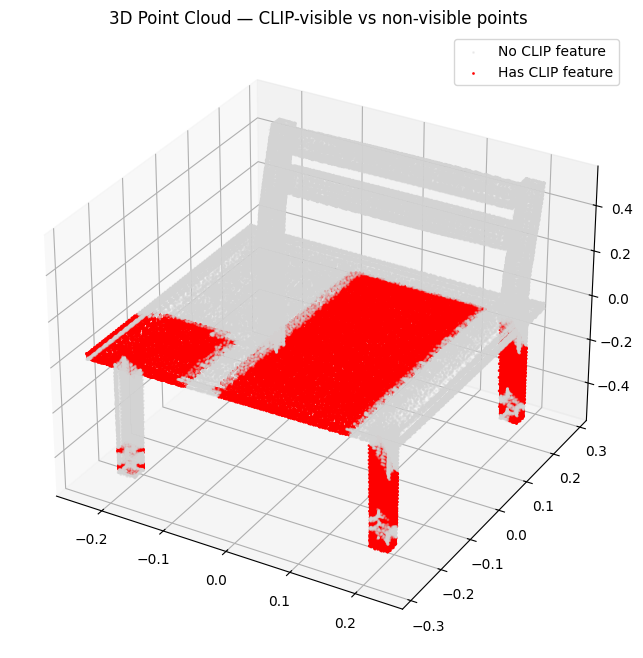

In [ ]:
# visualize 3D points with CLIP vs no-CLIP

def visualize_visible_points(points, is_visible, s=1, figsize=(8, 8)):
    if hasattr(is_visible, "cpu"):
        is_visible = is_visible.cpu().numpy()
    if hasattr(points, "cpu"):
        points = points.cpu().numpy()

    vis = is_visible
    non_vis = ~vis

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[non_vis, 0], points[non_vis, 1], points[non_vis, 2],
               s=s, c='lightgray', alpha=0.3, label="No CLIP feature")
    ax.scatter(points[vis, 0], points[vis, 1], points[vis, 2],
               s=s, c='red', alpha=0.9, label="Has CLIP feature")

    ax.set_title("3D Point Cloud — CLIP-visible vs non-visible points")
    ax.legend()
    plt.show()

visualize_visible_points(points, is_visible, s=1)


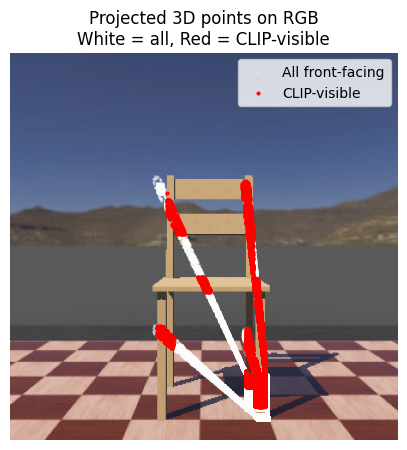

In [ ]:
# 2D overlay of projections

plt.figure(figsize=(5, 8))
plt.imshow(rgb)
plt.axis("off")

# all front-facing points
plt.scatter(aligned_u[in_front], aligned_v[in_front], s=1, c='white', alpha=0.3, label="All front-facing")

# CLIP-visible points
plt.scatter(aligned_u[is_visible.cpu().numpy()], aligned_v[is_visible.cpu().numpy()],
            s=4, c='red', alpha=0.9, label="CLIP-visible")

plt.title("Projected 3D points on RGB\nWhite = all, Red = CLIP-visible")
plt.legend()
plt.show()


## Difference in Webot World Coordinates and 3D object world coordinates

In [27]:
print("Points min:", points.min(axis=0))
print("Points max:", points.max(axis=0))
print("Points mean:", points.mean(axis=0))


Points min: [-0.23992461 -0.28552353 -0.50241655]
Points max: [0.23680502 0.28364944 0.4987536 ]
Points mean: [-0.00105018  0.05160055  0.04388733]


In [28]:
# camera position in world (from extrinsic)
C_world = -w2c[:3,:3].T @ w2c[:3,3]
print("Camera world position:", C_world)


Camera world position: [ 0.3123208   0.5253498  -0.64200413]


In [29]:
print("Point cloud centroid:", points.mean(axis=0))


Point cloud centroid: [-0.00105018  0.05160055  0.04388733]


## Using Camera extrinsic and Object pose from Webots world

In [1]:
import numpy as np
import trimesh
from PIL import Image
import matplotlib.pyplot as plt


In [2]:

ply_path = "gaussians/single/chair_webots.ply"
rgb_path = "chair_webots/image.jpg"
mask_path = "chair_webots/0.png"

intrinsics_txt = "chair_webots/intrinsics.txt"
extrinsic_camera_txt = "chair_webots/extrinsic_camera.txt"  
# Webots chair pose from .wbt
chair_translation = np.array([1.43, -0.54, 0.0], dtype=np.float32)
chair_axis = np.array([0.0, 0.0, 1.0], dtype=np.float32)
chair_angle = 3.14159  # ~pi

# Rotate point cloud by +30° about Z before placing it in world?
use_rot30 = True
rot30_deg = 30.0


In [5]:
# Load point cloud
pc = trimesh.load(ply_path, process=False)
if hasattr(pc, "vertices"):
    points = np.asarray(pc.vertices, dtype=np.float32)
else:
    points = np.asarray(pc.points, dtype=np.float32)

print("points shape:", points.shape)
print("points min:", points.min(axis=0))
print("points max:", points.max(axis=0))
print("points mean:", points.mean(axis=0))

# Load image
img_pil = Image.open(rgb_path).convert("RGB")
rgb = np.array(img_pil)
H, W = rgb.shape[:2]
print("Image size (H,W):", (H, W))

# Load mask (optional)
mask = None
if mask_path is not None:
    mask_pil = Image.open(mask_path).convert("L")
    mask = (np.array(mask_pil) > 0).astype(np.uint8)
    print("Mask loaded:", mask.shape, "mask sum:", mask.sum())


points shape: (140640, 3)
points min: [-0.23992461 -0.28552353 -0.50241655]
points max: [0.23680502 0.28364944 0.4987536 ]
points mean: [-0.00105018  0.05160055  0.04388733]
Image size (H,W): (324, 324)
Mask loaded: (324, 324) mask sum: 6856


In [6]:
import re

def load_webots_K(path: str) -> np.ndarray:
    txt = open(path, "r").read()
    # grab all floats from file
    nums = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", txt)]
    # We expect at least 9 numbers for K
    if len(nums) < 9:
        raise ValueError(f"Could not parse K from {path}. Found {len(nums)} numbers.")
    K = np.array(nums[:9], dtype=np.float32).reshape(3, 3)
    return K

K = load_webots_K(intrinsics_txt)
print("Loaded K:\n", K)


Loaded K:
 [[348.622   0.    162.   ]
 [  0.    348.622 162.   ]
 [  0.      0.      1.   ]]


In [7]:
def load_webots_extrinsic_3x4(path: str) -> np.ndarray:
    txt = open(path, "r").read().strip().splitlines()
    rows = []
    for line in txt:
        # collect lines that contain 4 floats
        vals = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", line)
        if len(vals) == 4:
            rows.append([float(v) for v in vals])
    if len(rows) != 3:
        raise ValueError(f"Could not parse 3 rows of 4 floats from {path}. Got {len(rows)} rows.")
    E = np.array(rows, dtype=np.float32)  # 3x4
    T = np.eye(4, dtype=np.float32)
    T[:3, :4] = E
    return T

T_raw = load_webots_extrinsic_3x4(extrinsic_camera_txt)
print("Loaded T_raw (4x4):\n", T_raw)


Loaded T_raw (4x4):
 [[ 1.0000000e+00  9.7912001e-05 -0.0000000e+00  3.1232080e-01]
 [-9.7912001e-05  1.0000000e+00  0.0000000e+00  5.2534980e-01]
 [ 0.0000000e+00 -0.0000000e+00  1.0000000e+00 -6.4200413e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [26]:
def project_points(points, K, w2c):
    """
    points: (N,3) in WORLD coordinates
    K: (3,3)
    w2c: (4,4)
    Returns pixels (N,2), depths (N,)
    """
    N = points.shape[0]
    pts_h = np.hstack([points, np.ones((N, 1), dtype=np.float32)])
    pts_cam = (w2c @ pts_h.T).T
    X, Y, Z = pts_cam[:, 0], pts_cam[:, 1], pts_cam[:, 2]

    eps = 1e-8
    Z_safe = np.where(np.abs(Z) < eps, eps, Z)
    x = X / Z_safe
    y = -Y / Z_safe

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    u = fx * x + cx
    v = fy * y + cy

    pixels = np.stack([u, v], axis=-1).astype(np.float32)
    return pixels, Z.astype(np.float32)

def choose_w2c(points_world, K, T_raw):
    """
    T_raw might be c2w or w2c. Try both and pick the one that yields more Z>0.
    """
    T_inv = np.linalg.inv(T_raw)

    _, z1 = project_points(points_world, K, T_raw)
    _, z2 = project_points(points_world, K, T_inv)

    c1 = (z1 > 0).sum()
    c2 = (z2 > 0).sum()

    print("Points in front: T_raw =", c1, ", inv(T_raw) =", c2)
    if c2 > c1:
        print("=> Using inv(T_raw) as w2c")
        return T_inv
    else:
        print("=> Using T_raw as w2c")
        return T_raw


In [27]:
def rotate_z(points, angle_rad):
    R = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad),  np.cos(angle_rad), 0],
        [0,                 0,                1]
    ], dtype=np.float32)
    return points @ R.T

points_local = points.astype(np.float32)

if use_rot30:
    angle_rad = np.deg2rad(rot30_deg)
    points_local = rotate_z(points_local, angle_rad)
    print(f"Rotated point cloud by +{rot30_deg}° around Z.")
else:
    print("Rotation disabled (using original points).")

print("points_local shape:", points_local.shape)


Rotated point cloud by +30.0° around Z.
points_local shape: (140640, 3)


In [28]:
def axis_angle_to_R(axis, angle):
    axis = axis.astype(np.float32)
    axis = axis / (np.linalg.norm(axis) + 1e-8)
    x, y, z = axis
    c = np.cos(angle)
    s = np.sin(angle)
    C = 1 - c
    R = np.array([
        [c + x*x*C,     x*y*C - z*s, x*z*C + y*s],
        [y*x*C + z*s,   c + y*y*C,   y*z*C - x*s],
        [z*x*C - y*s,   z*y*C + x*s, c + z*z*C]
    ], dtype=np.float32)
    return R

R_obj = axis_angle_to_R(chair_axis, chair_angle)
t_obj = chair_translation

points_world = (R_obj @ points_local.T).T + t_obj

print("points_world mean:", points_world.mean(axis=0))
print("points_world min:", points_world.min(axis=0))
print("points_world max:", points_world.max(axis=0))


points_world mean: [ 1.4567094  -0.58416295  0.04388818]
points_world min: [ 1.0872989  -0.8886897  -0.50241655]
points_world max: [ 1.7501535  -0.17357457  0.4987536 ]


In [29]:
w2c = choose_w2c(points_world, K, T_raw)
pixels, depths = project_points(points_world, K, w2c)

print("Raw u range:", pixels[:,0].min(), pixels[:,0].max())
print("Raw v range:", pixels[:,1].min(), pixels[:,1].max())
print("Points in front (Z>0):", (depths > 0).sum(), "/", len(depths))


Points in front: T_raw = 0 , inv(T_raw) = 140640
=> Using inv(T_raw) as w2c
Raw u range: 488.7054 3679.3232
Raw v range: 518.4148 3576.0151
Points in front (Z>0): 140640 / 140640


In image: 0 / 140640


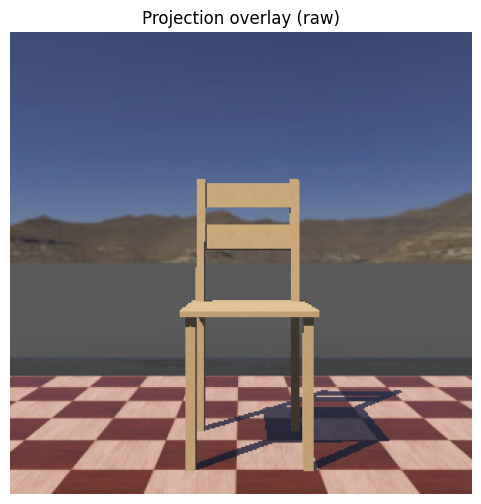

In [30]:
in_front = depths > 0
u = pixels[in_front, 0]
v = pixels[in_front, 1]

in_img = (u >= 0) & (u < W) & (v >= 0) & (v < H)

print("In image:", in_img.sum(), "/", in_front.sum())

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.scatter(u[in_img], v[in_img], s=0.5)  # tiny points
plt.title("Projection overlay (raw)")
plt.axis("off")
plt.show()


In [31]:
# Chair center in world (use the point cloud centroid you computed)
chair_center_world = points_world.mean(axis=0)

chair_center_cam = (w2c @ np.array([*chair_center_world, 1.0], dtype=np.float32))[:3]
print("chair_center_world:", chair_center_world)
print("chair_center_cam (X,Y,Z):", chair_center_cam)

# Also print normalized direction on image plane
x = chair_center_cam[0] / chair_center_cam[2]
y = chair_center_cam[1] / chair_center_cam[2]
u = K[0,0]*x + K[0,2]
v = K[1,1]*y + K[1,2]
print("Projected center (u,v):", u, v)


chair_center_world: [ 1.4567094  -0.58416295  0.04388818]
chair_center_cam (X,Y,Z): [ 1.1444973 -1.1094007  0.6858923]
Projected center (u,v): 743.71954 -401.88086


In [32]:
import itertools
import numpy as np

def project_with_axis_map(points_world, K, w2c, A):
    """
    A: 3x3 axis mapping applied in camera coords: Xc' = A @ Xc
    """
    N = points_world.shape[0]
    pts_h = np.hstack([points_world, np.ones((N,1), dtype=np.float32)])
    pts_cam = (w2c @ pts_h.T).T[:, :3]  # (N,3) in "webots camera frame"

    # Apply axis mapping
    pts_cam2 = (A @ pts_cam.T).T
    X, Y, Z = pts_cam2[:,0], pts_cam2[:,1], pts_cam2[:,2]

    eps = 1e-8
    Zs = np.where(np.abs(Z) < eps, eps, Z)
    u = K[0,0] * (X / Zs) + K[0,2]
    v = K[1,1] * (Y / Zs) + K[1,2]
    return u, v, Z

def score_mapping(u, v, Z, W, H, mask=None):
    in_front = Z > 0
    u2 = u[in_front]; v2 = v[in_front]
    in_img = (u2 >= 0) & (u2 < W) & (v2 >= 0) & (v2 < H)
    count_in = int(in_img.sum())

    if mask is None or count_in == 0:
        return count_in, 0, count_in

    uu = np.round(u2[in_img]).astype(int)
    vv = np.round(v2[in_img]).astype(int)
    on_mask = mask[vv, uu] > 0
    count_mask = int(on_mask.sum())

    # Score prioritizes mask overlap heavily, then in-image count
    score = count_mask * 10 + count_in
    return score, count_mask, count_in

def all_axis_maps():
    # Generate 3x3 matrices with one +/-1 in each row/col (permutation + sign flips)
    mats = []
    for perm in itertools.permutations([0,1,2]):
        P = np.zeros((3,3), dtype=np.float32)
        for i,j in enumerate(perm):
            P[i,j] = 1.0
        for signs in itertools.product([1.0, -1.0], repeat=3):
            S = np.diag(signs).astype(np.float32)
            A = S @ P
            mats.append(A)
    return mats

best = None
best_info = None

for A in all_axis_maps():
    u, v, Z = project_with_axis_map(points_world, K, w2c, A)
    score, count_mask, count_in = score_mapping(u, v, Z, W, H, mask=mask)
    if best is None or score > best:
        best = score
        best_info = (A, score, count_mask, count_in, (u.min(), u.max(), v.min(), v.max()))

A_best, score, count_mask, count_in, ranges = best_info
print("BEST A:\n", A_best)
print("score:", score, "on_mask:", count_mask, "in_img:", count_in)
print("u/v ranges:", ranges)


BEST A:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
score: 0 on_mask: 0 in_img: 0
u/v ranges: (np.float32(488.7054), np.float32(3679.3232), np.float32(-3252.0151), np.float32(-194.41476))


In [33]:
print("RGB size:", (W,H), "K cx,cy:", (K[0,2], K[1,2]))


RGB size: (324, 324) K cx,cy: (np.float32(162.0), np.float32(162.0))


In [34]:
points_local2 = points_local[:, [0,2,1]]


In [35]:
import numpy as np

# ---- camera pose from w2c ----
R_w2c = w2c[:3, :3]
R_c2w = R_w2c.T

# Camera position in world
C_world = -R_c2w @ w2c[:3, 3]

# Camera forward direction in world (+Z axis of camera)
camera_forward_world = R_c2w @ np.array([0, 0, 1], dtype=np.float32)

# Chair center in world (you already computed this)
chair_center_world = points_world.mean(axis=0)

# Direction from camera to chair
dir_cam_to_chair = chair_center_world - C_world
dir_cam_to_chair /= np.linalg.norm(dir_cam_to_chair)

# How well they align
cos_angle = float(np.dot(camera_forward_world, dir_cam_to_chair))

print("Camera position (world):", C_world)
print("Camera forward (world):", camera_forward_world)
print("Chair center (world):", chair_center_world)
print("Direction cam → chair:", dir_cam_to_chair)
print("cos(angle) =", cos_angle)


Camera position (world): [ 0.3123208   0.5253498  -0.64200413]
Camera forward (world): [0. 0. 1.]
Chair center (world): [ 1.4567094  -0.58416295  0.04388818]
Direction cam → chair: [ 0.65949494 -0.63939655  0.39527005]
cos(angle) = 0.39527004957199097
